# Gaussian Mixture Models

The *k*-means clustering model explored in the previous section is simple and relatively easy to understand, but its simplicity leads to practical challenges in its application.
In particular, the non-probabilistic nature of *k*-means and its use of simple distance-from-cluster-center to assign cluster membership leads to poor performance for many real-world situations.
In this section we will take a look at Gaussian mixture models (GMMs), which can be viewed as an extension of the ideas behind *k*-means, but can also be a powerful tool for estimation beyond simple clustering.

We begin with the standard imports:

In [49]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

## Motivating GMM: Weaknesses of k-Means

Let's take a look at some of the weaknesses of *k*-means and think about how we might improve the cluster model.
As we saw in the previous section, given simple, well-separated data, *k*-means finds suitable clustering results.

For example, if we have simple blobs of data, the *k*-means algorithm can quickly label those clusters in a way that closely matches what we might do by eye:

In [50]:
# Generate some data
from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=400, centers=4,
                       cluster_std=0.60, random_state=0)
X = X[:, ::-1] # flip axes for better plotting

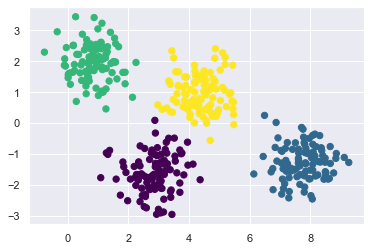

In [57]:
# Plot the data with K Means Labels
from sklearn.cluster import KMeans
kmeans = KMeans(4, random_state=0)
labels = kmeans.fit(X).predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');
#temp_labels = labels[:10];
#print(temp_labels)

## Generalizing E–M: Gaussian Mixture Models

A Gaussian mixture model (GMM) attempts to find a mixture of multi-dimensional Gaussian probability distributions that best model any input dataset.
In the simplest case, GMMs can be used for finding clusters in the same manner as *k*-means:

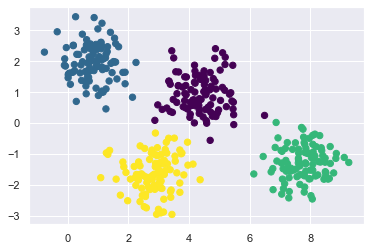

In [60]:
from sklearn.mixture import GaussianMixture as GMM
gmm = GMM(n_components=4).fit(X)
labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

But because GMM contains a probabilistic model under the hood, it is also possible to find probabilistic cluster assignments—in Scikit-Learn this is done using the ``predict_proba`` method.
This returns a matrix of size ``[n_samples, n_clusters]`` which measures the probability that any point belongs to the given cluster:

In [66]:
probs = gmm.predict_proba(X)
#np.size(probs)
print(probs[:10].round(3))

[[0.531 0.    0.469 0.   ]
 [0.    0.    0.    1.   ]
 [0.    0.    0.    1.   ]
 [1.    0.    0.    0.   ]
 [0.    0.    0.    1.   ]
 [0.    0.    1.    0.   ]
 [0.    1.    0.    0.   ]
 [0.986 0.    0.    0.014]
 [0.    0.    0.    1.   ]
 [0.    1.    0.    0.   ]]


We can visualize this uncertainty by, for example, making the size of each point proportional to the certainty of its prediction; looking at the following figure, we can see that it is precisely the points at the boundaries between clusters that reflect this uncertainty of cluster assignment:

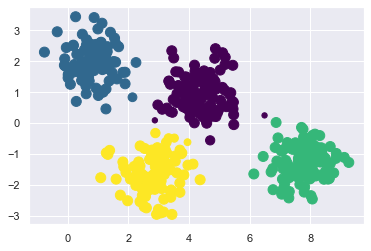

In [68]:
size = 100 * probs.max(1) ** 2  # square emphasizes differences
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=size);

Under the hood, a Gaussian mixture model is very similar to *k*-means: it uses an expectation–maximization approach which qualitatively does the following:

1. Choose starting guesses for the location and shape

2. Repeat until converged:

   1. *E-step*: for each point, find weights encoding the probability of membership in each cluster
   2. *M-step*: for each cluster, update its location, normalization, and shape based on *all* data points, making use of the weights

The result of this is that each cluster is associated not with a hard-edged sphere, but with a smooth Gaussian model.
Just as in the *k*-means expectation–maximization approach, this algorithm can sometimes miss the globally optimal solution, and thus in practice multiple random initializations are used.

Let's create a function that will help us visualize the locations and shapes of the GMM clusters by drawing ellipses based on the GMM output:

In [69]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

With this in place, we can take a look at what the four-component GMM gives us for our initial data:

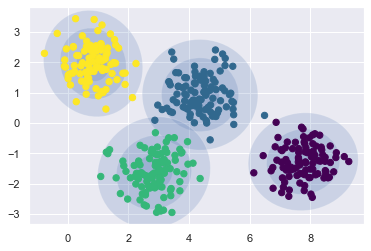

In [70]:
gmm = GMM(n_components=4, random_state=42)
plot_gmm(gmm, X)

Similarly, we can use the GMM approach to fit our stretched dataset; allowing for a full covariance the model will fit even very oblong, stretched-out clusters:

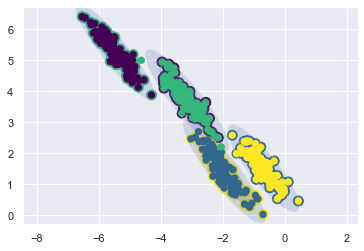

In [83]:
rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2, 2))
plt.scatter(X_stretched[:, 0], X_stretched[:, 1], c=labels, cmap='viridis', s=size);

#gmm = GMM(n_components=4, random_state=42)
gmm = GMM(n_components=4, covariance_type='full', random_state=42)
plot_gmm(gmm, X_stretched)

### Choosing the covariance type

If you look at the details of the preceding fits, you will see that the ``covariance_type`` option was set differently within each.
This hyperparameter controls the degrees of freedom in the shape of each cluster; it is essential to set this carefully for any given problem.
The default is ``covariance_type="diag"``, which means that the size of the cluster along each dimension can be set independently, with the resulting ellipse constrained to align with the axes.
A slightly simpler and faster model is ``covariance_type="spherical"``, which constrains the shape of the cluster such that all dimensions are equal. The resulting clustering will have similar characteristics to that of *k*-means, though it is not entirely equivalent.
A more complicated and computationally expensive model (especially as the number of dimensions grows) is to use ``covariance_type="full"``, which allows each cluster to be modeled as an ellipse with arbitrary orientation.

We can see a visual representation of these three choices for a single cluster within the following figure:

## GMM as *Density Estimation*

Though GMM is often categorized as a clustering algorithm, fundamentally it is an algorithm for *density estimation*.
That is to say, the result of a GMM fit to some data is technically not a clustering model, but a generative probabilistic model describing the distribution of the data.

As an example, consider some data generated from Scikit-Learn's ``make_moons`` function, which we saw in [In Depth: K-Means Clustering](05.11-K-Means.ipynb):

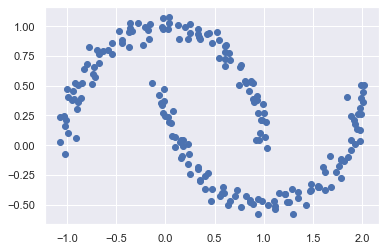

In [84]:
from sklearn.datasets import make_moons
Xmoon, ymoon = make_moons(200, noise=.05, random_state=0)
plt.scatter(Xmoon[:, 0], Xmoon[:, 1]);

If we try to fit this with a two-component GMM viewed as a clustering model, the results are not particularly useful:

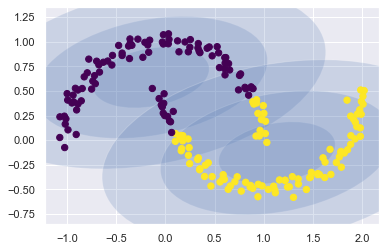

In [85]:
gmm2 = GMM(n_components=2, covariance_type='full', random_state=0)
plot_gmm(gmm2, Xmoon)

But if we instead use many more components and ignore the cluster labels, we find a fit that is much closer to the input data:

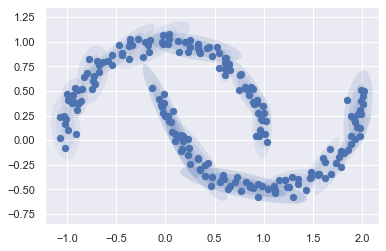

In [86]:
gmm16 = GMM(n_components=16, covariance_type='full', random_state=0)
plot_gmm(gmm16, Xmoon, label=False)

GMM is convenient as a flexible means of modeling an arbitrary multi-dimensional distribution of data.

### How many components?

The fact that GMM is a generative model gives us a natural means of determining the optimal number of components for a given dataset.
A generative model is inherently a probability distribution for the dataset, and so we can simply evaluate the *likelihood* of the data under the model, using cross-validation to avoid over-fitting.
Another means of correcting for over-fitting is to adjust the model likelihoods using some analytic criterion such as the [Akaike information criterion (AIC)](https://en.wikipedia.org/wiki/Akaike_information_criterion) or the [Bayesian information criterion (BIC)](https://en.wikipedia.org/wiki/Bayesian_information_criterion).
Scikit-Learn's ``GMM`` estimator actually includes built-in methods that compute both of these, and so it is very easy to operate on this approach.

Let's look at the AIC and BIC as a function as the number of GMM components for our moon dataset:

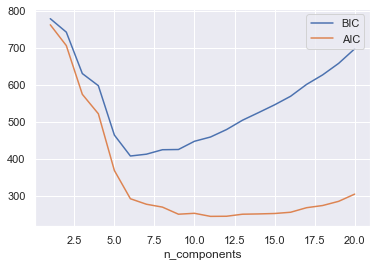

In [88]:
n_components = np.arange(1, 21)
models = [GMM(n, covariance_type='full', random_state=0).fit(Xmoon)
          for n in n_components]

plt.plot(n_components, [m.bic(Xmoon) for m in models], label='BIC')
plt.plot(n_components, [m.aic(Xmoon) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

The optimal number of clusters is the value that minimizes the AIC or BIC, depending on which approximation we wish to use. The AIC tells us that our choice of 16 components above was probably too many: around 8-12 components would have been a better choice.
As is typical with this sort of problem, the BIC recommends a simpler model.

Notice the important point: this choice of number of components measures how well GMM works *as a density estimator*, not how well it works *as a clustering algorithm*.
I'd encourage you to think of GMM primarily as a density estimator, and use it for clustering only when warranted within simple datasets.